In [2]:
#import kaggle
import pandas as pd
import numpy as np
import os
from skimage import io, transform
import matplotlib.pyplot as plt

import cv2

import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def fetch_data():
    kaggle.api.authenticate()
    kaggle.api.dataset_download_files('fournierp/captcha-version-2-images', path=r'dataset', unzip=True)
#fetch_data()

In [50]:
# setup
batch_size_train = 32
batch_size_test = 135

random_seed = 1
torch.manual_seed(random_seed)
log_interval = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
def imshow(image):
    fig, ax = plt.subplots()
    image = image.numpy()
    image = np.transpose(image, (1,2,0))
    ax.imshow(image, cmap = 'gray')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [8]:
#  for item in os.listdir("./dataset/samples"):
#         assert len(item) == 9

In [26]:
# get tokens
alphabet = "abcdefghijklmnopqrstuvwxyz"
numbers=map(str, list(range(0,10)))

characters = list(alphabet + alphabet.upper()) + list(numbers)
n_tokens = len(characters)
print(n_tokens)
token_dict = {i: characters[i] for i in range(len(characters))}
token_dict_reversed = {v: k for k, v in token_dict.items()}
print(token_dict_reversed)


62
{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25, 'A': 26, 'B': 27, 'C': 28, 'D': 29, 'E': 30, 'F': 31, 'G': 32, 'H': 33, 'I': 34, 'J': 35, 'K': 36, 'L': 37, 'M': 38, 'N': 39, 'O': 40, 'P': 41, 'Q': 42, 'R': 43, 'S': 44, 'T': 45, 'U': 46, 'V': 47, 'W': 48, 'X': 49, 'Y': 50, 'Z': 51, '0': 52, '1': 53, '2': 54, '3': 55, '4': 56, '5': 57, '6': 58, '7': 59, '8': 60, '9': 61}


In [41]:
class CAPTCHADataset(torch.utils.data.Dataset):
    def __init__(self, path, transforms=None):
        self.path = path
        self.transforms = transforms

        # store the name of the image as that is the target/label
        self.targets = []
        self.paths = []

        images_path = self.path + "/"
        self.images = os.listdir(images_path)
        self.images.sort()
        for i in self.images:
            self.targets.append(i[:5])
            self.paths.append(images_path + i)

    def __len__(self):
        return len(self.images)


    def __getitem__(self, idx):
        """
        idx: Index of the image
        Return: dictionary of the image tensor and target tensor
        """
        img = cv2.imread(self.paths[idx])
        name = self.targets[idx]
        label = [token_dict_reversed[char] for char in name]

        # convert to onehot vector matrix
        label_onehot = F.one_hot(torch.tensor(label), num_classes=n_tokens).float()


        # apply transformations to the image
        if self.transforms:
            img = self.transforms(img)

        return img, label_onehot


In [42]:
# do random split ~ 75% train, 12.5% for validation and test set
from torch.utils.data import random_split
def getDataLoaders(transform=None):
    # load data set

    dataset =  CAPTCHADataset("/content/drive/MyDrive/captcha/dataset/samples", transforms = transform)
    captcha_training_set, captcha_validation_set = random_split(dataset, [800, 1070-800])
    captcha_validation_set, captcha_test_set = random_split(captcha_validation_set, [135, 135])


    train_loader = torch.utils.data.DataLoader(captcha_training_set, batch_size=batch_size_train, shuffle=True)

    validation_loader = torch.utils.data.DataLoader(captcha_validation_set, batch_size=batch_size_train, shuffle=True)

    test_loader = torch.utils.data.DataLoader(captcha_test_set, batch_size=batch_size_test, shuffle=True)

    return train_loader, validation_loader, test_loader

transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Resize((256,256)),
         transforms.Normalize((0.1307,), (0.3081,))
        ]
    )

train_loader, validation_loader, test_loader = getDataLoaders(transform)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([32, 3, 256, 256])
torch.Size([32, 5, 62])
torch.Size([3, 256, 256])


<Axes: >

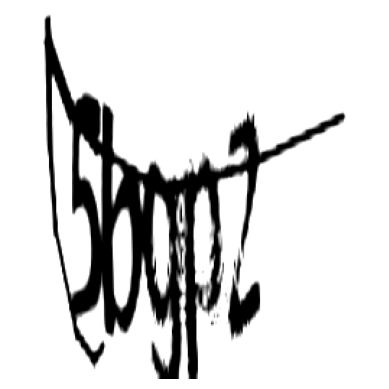

In [43]:
# check a sample
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.shape)
print(example_targets.shape)
print(example_data[0].unsqueeze(0)[0].shape)
imshow(example_data[0].unsqueeze(0)[0])

### Calculate the input size of the fully connected network

In [44]:
def calculate_fc_inputsize(image_size:int,
                           filter_sizes:list,
                           max_pool_sizes:list,
                           final_layer_feature_maps:int,
                           conv_stride:list = None,
                           conv_padding:list = None,
                           print_ = False
                          ):
    """
    Calculates the flattened output size of the final convolution layer. Assumes H=W
    """
    import math
    conv = image_size
    for i in range(0, len(filter_sizes)):
        stride = conv_stride[i]
        pad = conv_padding[i]
        conv = (conv + 2*pad - filter_sizes[i] + stride) / stride
        conv = (conv - max_pool_sizes[i] + 2) // 2
        if print_:
            print("Convolution {} output size: {}**2".format(i, conv))
    return int((conv**2)*final_layer_feature_maps)

calculate_fc_inputsize(image_size=256,
                       filter_sizes=[5,5,3,3,3],
                       max_pool_sizes=[2,3,2,3,2],
                       final_layer_feature_maps=32,
                       conv_stride = [1,1,1,1,1],
                       conv_padding = [0,0,0,0,0],
                       print_=True
                      )

Convolution 0 output size: 126.0**2
Convolution 1 output size: 60.0**2
Convolution 2 output size: 29.0**2
Convolution 3 output size: 13.0**2
Convolution 4 output size: 5.0**2


800

## Model Architecture

In [45]:
class Net(nn.Module):
    def __init__(self, input_size, num_feature_maps, kernel_sizes, padding=[0]*5, stride=[1]*5):
        super(Net, self).__init__()
        self.num_feature_maps = num_feature_maps
        self.kernel_sizes = kernel_sizes

        conv1_num_feature_maps, conv2_num_feature_maps, conv3_num_feature_maps, conv4_num_feature_maps, conv5_num_feature_maps = self.num_feature_maps.values()

        self.conv_output_size = calculate_fc_inputsize(input_size, list(self.kernel_sizes.values()), [2,3,2,3,2], conv5_num_feature_maps, stride, padding)


        self.conv1 = nn.Sequential(
            nn.Conv2d(3, conv1_num_feature_maps, kernel_size=self.kernel_sizes['conv1']),
            nn.BatchNorm2d(conv1_num_feature_maps),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(conv1_num_feature_maps, conv2_num_feature_maps, kernel_size=self.kernel_sizes['conv2']),
            nn.BatchNorm2d(conv2_num_feature_maps),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(conv2_num_feature_maps, conv3_num_feature_maps, kernel_size=self.kernel_sizes['conv3']),
            nn.BatchNorm2d(conv3_num_feature_maps),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(conv3_num_feature_maps, conv4_num_feature_maps, kernel_size=self.kernel_sizes['conv4']),
            nn.BatchNorm2d(conv4_num_feature_maps),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(conv4_num_feature_maps, conv5_num_feature_maps, kernel_size=self.kernel_sizes['conv5']),
            nn.BatchNorm2d(conv5_num_feature_maps),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )


        self.fc1 = nn.Sequential(
            nn.Linear(32, 100),
            nn.ReLU()
        )

        self.fc2 = nn.Sequential(
            nn.Linear(100, 62)
        )

        self.out_weights = nn.parameter.Parameter(torch.randn((25, 5))) # for converting the tensors to (BATCH SIZE, LEN_TEXT, NUM_CLASSES)


    def forward(self, x):
        """
        Forward for network
        input: x: pytorch tensor of size [Batchsize, 3, 256, 256]
        returns: pytorch tensor of size [32, 62]
        """
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        # fully connected part
        x = torch.flatten(x, start_dim=2)
        # print(x.shape)
        x = torch.matmul(x, self.out_weights)
        # print(x.shape)
        x = x.transpose(-2,-1)
        x = self.fc1(x)
        x = self.fc2(x)

        # final activation via softmax
        x = F.log_softmax(x, dim = -1)
        return x

### Check forward pass for an image

In [46]:
random_seed = 1
torch.manual_seed(random_seed)

num_feature_maps = {
    "conv1": 6,
    "conv2": 12,
    "conv3": 18,
    "conv4": 24,
    "conv5": 32
}

kernel_sizes = {
    "conv1": 5,
    "conv2": 5,
    "conv3": 3,
    "conv4": 3,
    "conv5": 3
}

with torch.no_grad():
    model = Net(256, num_feature_maps, kernel_sizes)
    x = example_data
    print(x.shape)
    output = model(x)
    print(output.shape)
    print(output[0])
    print(torch.argmax(output[0], dim=-1))

torch.Size([32, 3, 256, 256])
torch.Size([32, 5, 62])
tensor([[-5.3354, -3.4237, -4.1362, -3.1243, -4.4558, -7.1750, -7.3741, -5.3039,
         -2.8764, -5.2030, -5.5613, -4.9160, -3.9464, -8.0848, -3.4463, -7.8033,
         -6.0169, -6.1749, -6.4631, -5.1179, -5.7050, -5.9637, -2.4687, -6.3758,
         -5.9156, -4.6289, -3.7186, -5.0791, -4.3201, -5.7618, -6.8382, -2.6084,
         -4.1255, -4.6217, -5.9902, -5.1334, -4.9573, -5.1072, -3.4824, -3.4895,
         -3.1084, -4.1030, -4.4675, -4.0215, -4.4255, -5.9665, -5.9571, -6.2539,
         -3.1218, -5.3860, -4.1441, -5.1898, -4.2775, -3.3427, -2.8059, -4.0644,
         -3.3224, -4.8775, -3.3514, -5.3258, -6.7096, -3.8553],
        [-5.5785, -4.1931, -4.2651, -2.5088, -5.6898, -8.9629, -9.1088, -6.7763,
         -2.2547, -4.7346, -5.3554, -5.6197, -4.6683, -9.0030, -4.9956, -9.0552,
         -7.4644, -7.2759, -7.5883, -4.9864, -7.1307, -6.9715, -2.5882, -7.3525,
         -6.3546, -4.4242, -3.2528, -5.3070, -4.6730, -5.5506, -7.7863, 

In [47]:
example_targets[:3]

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [48]:
F.cross_entropy(output[:3], example_targets[:3].float())

tensor(0.2339)

## Train model

In [49]:
from torch import optim
class Trainer:
    def __init__(self,
                 n_epoch:int,
                 train_loader,
                 validation_loader):

        self.n_epoch = n_epoch

        self.train_loader = train_loader
        self.validation_loader = validation_loader
        self.net = Net(256, num_feature_maps, kernel_sizes)
        self.net.to(device)
        self.optimizer = optim.Adam(lr=0.01, params=self.net.parameters()) #optim.Adam(lr=0.001, params=self.net.parameters())
        self.loss = nn.CrossEntropyLoss()

        self.chars = None
        self.val_char = None

    def train(self):
        for epoch in range(1, self.n_epoch + 1):
          error = self.train_loop(epoch)
          print(error)
          self.validation()
    def train_loop(self, epoch):
        losses = []
        for idx, (x, y) in enumerate(self.train_loader):
          x = x.to(device)
          y = y.to(device)
          self.optimizer.zero_grad()

          output = self.net(x)
          loss = F.cross_entropy(output, y)
          losses.append(loss.item())
          loss.backward()

          self.optimizer.step()

          if idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, idx * len(x), len(self.train_loader.dataset),
            100. * idx / len(self.train_loader), loss.item()))


        return np.mean(losses)

    def validation(self):
        val_loss_list = []
        for idx, (x, y) in enumerate(self.validation_loader):
          x = x.to(device)
          y = y.to(device)
          with torch.no_grad():
            validation_output = self.net(x)
            loss_val = F.cross_entropy(validation_output, y)
            print("Validation_loss: {}".format(loss_val))
            y_pos = torch.argmax(y,dim=-1).detach().cpu().numpy()
            chars = torch.argmax(validation_output,dim=-1).detach().cpu().numpy()
            vfunc = np.vectorize(token_dict.get)

            self.chars = vfunc(chars)
            self.val_char = vfunc(y_pos)
            #print("predicted:", vfunc(chars), "target:", vfunc(y_pos))
            if idx % log_interval==0:
              print("Validation_loss: {}".format(loss_val))

    def get_chars(self):
      return self.chars, self.val_char


trainer = Trainer(15, train_loader, validation_loader)
trainer.train()

Train Epoch: 1 [0/800 (0%)]	Loss: 0.187302
Train Epoch: 1 [320/800 (40%)]	Loss: 0.136805
Train Epoch: 1 [640/800 (80%)]	Loss: 0.124095
0.14114606738090515
Validation_loss: 0.1281026005744934
Validation_loss: 0.1281026005744934
Validation_loss: 0.13110274076461792
Validation_loss: 0.12972325086593628
Validation_loss: 0.12209649384021759
Validation_loss: 0.12654376029968262
Train Epoch: 2 [0/800 (0%)]	Loss: 0.123782
Train Epoch: 2 [320/800 (40%)]	Loss: 0.117343
Train Epoch: 2 [640/800 (80%)]	Loss: 0.112557
0.11843091547489167
Validation_loss: 0.11596005409955978
Validation_loss: 0.11596005409955978
Validation_loss: 0.12067054212093353
Validation_loss: 0.11991316080093384
Validation_loss: 0.12245927006006241
Validation_loss: 0.11398198455572128
Train Epoch: 3 [0/800 (0%)]	Loss: 0.111706
Train Epoch: 3 [320/800 (40%)]	Loss: 0.110153
Train Epoch: 3 [640/800 (80%)]	Loss: 0.100842
0.1061182913184166
Validation_loss: 0.11011935770511627
Validation_loss: 0.11011935770511627
Validation_loss: 0.1

In [51]:
# Look at results from validation set
trainer.get_chars()

(array([['3', 'n', 'n', 'y', '7'],
        ['p', 'c', 'w', '7', 'e'],
        ['f', '5', 'g', '8', 'c'],
        ['f', 'n', '8', 'g', 'x'],
        ['6', 'f', '2', 'y', 'e'],
        ['d', 'y', 'w', 'c', 'e'],
        ['c', 'g', '8', 'f', 'g']], dtype='<U1'),
 array([['3', 'e', 'n', 'y', '7'],
        ['p', 'c', 'm', 'c', 'c'],
        ['5', '5', 'w', '5', 'c'],
        ['7', 'm', '8', 'p', 'x'],
        ['6', 'f', '2', 'y', 'c'],
        ['d', 'x', 'w', 'c', 'w'],
        ['e', 'e', '8', 'f', 'g']], dtype='<U1'))